In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import re
from collections import Counter
import zipfile
import os
import gensim.downloader as api
from nltk.corpus import stopwords

# Part 1: Data Preprocessing

In [52]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mazen\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mazen\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\mazen\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [53]:
from nltk.tag import _get_tagger
from nltk.data import find

def patched_get_tagger(lang='eng'):
    return nltk.PerceptronTagger(load=False)

nltk.tag._get_tagger = patched_get_tagger

In [54]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)            # Remove URLs
    text = re.sub(r'@\w+', '', text)                               # Remove usernames
    text = re.sub(r'#\w+', '', text)                               # Remove hashtags
    text = re.sub(r'[^\w\s]', '', text)                            # Remove emojis/punctuation
    text = re.sub(r'\s+', ' ', text).strip()                       # Remove extra whitespace
    
    # stop_words = set(stopwords.words('english')) - {'not', 'no', 'never', 'none'}
    # text = ' '.join(word for word in text.split() if word not in stop_words)
    
    return text

In [55]:
def get_wordnet_pos(word):
    if not isinstance(word, str) or not word.strip():
        return wordnet.NOUN  # default fallback
    try:
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
        return tag_dict.get(tag, wordnet.NOUN)
    except Exception:
        return wordnet.NOUN


## Preprocessing function

In [56]:
def preprocess_data(df):
    lemmatizer = WordNetLemmatizer()
    df['cleaned_text'] = df['text'].apply(clean_text)
    df['tokens'] = df['cleaned_text'].apply(word_tokenize)
    #df['tokens'] = df['tokens'].apply(lambda tokens: [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in tokens])
    df['tokens'] = df['tokens'].apply(lambda tokens: [
    lemmatizer.lemmatize(token, get_wordnet_pos(token)) 
    for token in tokens if isinstance(token, str) and token.strip()
    ])

    return df

## Data Augmentation

In [57]:
from nltk.corpus import wordnet
import random

nltk.download('wordnet')

def synonym_replacement(tokens, n=2):
    """Replace n random words with their synonyms."""
    new_tokens = tokens.copy()
    random_indices = random.sample(range(len(tokens)), min(n, len(tokens)))
    for idx in random_indices:
        word = new_tokens[idx]
        synonyms = [syn.lemmas()[0].name() for syn in wordnet.synsets(word) if syn.lemmas()]
        synonyms = [syn for syn in synonyms if syn != word and syn.isalnum()]
        if synonyms:
            new_tokens[idx] = random.choice(synonyms)
    return new_tokens

def augment_data(df, augmentation_factor=1, negative_augmentation_factor=3):
    augmented_data = []
    for _, row in df.iterrows():
        augmented_data.append((row['text'], row['label']))
        # Apply different augmentation factors based on label
        factor = negative_augmentation_factor if row['label'] == 0 else augmentation_factor
        for _ in range(factor):
            new_tokens = synonym_replacement(row['tokens'], n=2)
            new_text = ' '.join(new_tokens)
            augmented_data.append((new_text, row['label']))
    return pd.DataFrame(augmented_data, columns=['text', 'label'])

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mazen\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## EDA function

In [58]:
def perform_eda(df):
    plt.figure(figsize=(8, 6))
    sns.countplot(x='label', data=df)
    plt.title('Class Distribution')
    plt.show()

    df['tweet_length'] = df['tokens'].apply(len)
    plt.figure(figsize=(8, 6))
    sns.histplot(df['tweet_length'], bins=30)
    plt.title('Tweet Length Distribution')
    plt.show()

    for label in df['label'].unique():
        words = [word for tokens in df[df['label'] == label]['tokens'] for word in tokens]
        word_counts = Counter(words).most_common(10)
        words, counts = zip(*word_counts)
        plt.figure(figsize=(8, 6))
        sns.barplot(x=list(counts), y=list(words))
        plt.title(f'Most Frequent Words in Class {label}')
        plt.show()


## Tweet Dataset class

In [59]:
class TweetDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_len=50):
        self.texts = texts                    
        self.labels = labels                  
        self.vocab = vocab                    
        self.max_len = max_len                

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = [self.vocab.get(word, self.vocab['<UNK>']) for word in text]

        if len(encoding) > self.max_len:
            encoding = encoding[:self.max_len]
        else:
            encoding += [self.vocab['<PAD>']] * (self.max_len - len(encoding))

        return torch.tensor(encoding, dtype=torch.long), torch.tensor(label, dtype=torch.long)

    @staticmethod
    def build_vocab(tokens_list, min_freq=2):
        word_counts = Counter([word for tokens in tokens_list for word in tokens])
        vocab = {'<PAD>': 0, '<UNK>': 1}
        idx = 2
        for word, count in word_counts.items():
            if count >= min_freq:
                vocab[word] = idx
                idx += 1
        return vocab


## RNN-based Model

In [60]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_classes):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.rnn1 = nn.RNN(embed_size, hidden_size, batch_first=True)
        self.rnn2 = nn.RNN(hidden_size, hidden_size // 2, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_size // 2, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.rnn1(x)
        x, _ = self.rnn2(x)
        x = self.dropout(x[:, -1, :])  # Take the last hidden state
        out = self.fc(x)
        return out

## LSTM-based model

In [61]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_classes):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.lstm1 = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size // 2, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_size // 2, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = self.dropout(x[:, -1, :])  # Take the last hidden state
        out = self.fc(x)
        return out

## Feedforward-based model

In [62]:
class FeedforwardModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_classes):
        super(FeedforwardModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.fc1 = nn.Linear(embed_size, hidden_size * 2)  # Increased hidden size
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(hidden_size * 2, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = x.mean(dim=1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        out = self.fc3(x)
        return out

## Tuned Feedforward

In [ ]:
class FeedforwardModelTuned(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_classes):
        super(FeedforwardModelTuned, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.fc1 = nn.Linear(embed_size, hidden_size * 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.4)
        self.fc2 = nn.Linear(hidden_size * 2, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = x.mean(dim=1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        out = self.fc3(x)
        return out

## Enhanced LSTM

In [64]:
class EnhancedLSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_classes):
        super(EnhancedLSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.lstm1 = nn.LSTM(embed_size, hidden_size * 2, batch_first=True)  # Increased to 256
        self.lstm2 = nn.LSTM(hidden_size * 2, hidden_size, batch_first=True)
        self.batch_norm = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = torch.mean(x, dim=1)
        x = self.batch_norm(x)
        x = self.dropout(x)
        out = self.fc(x)
        return out

## Bi LSTM Model

In [65]:
class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_classes):
        super(BiLSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.bilstm = nn.LSTM(embed_size, hidden_size * 2, batch_first=True, bidirectional=True)
        self.attention = nn.Linear(hidden_size * 4, 1)  # Attention layer
        self.batch_norm = nn.BatchNorm1d(hidden_size * 4)
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(hidden_size * 4, num_classes)

    def forward(self, x):
        x = self.embedding(x)  # Shape: [batch_size, seq_len, embed_size]
        x, _ = self.bilstm(x)  # Shape: [batch_size, seq_len, hidden_size * 4]
        
        # Apply attention
        attn_weights = torch.softmax(self.attention(x), dim=1)  # Shape: [batch_size, seq_len, 1]
        x = torch.sum(x * attn_weights, dim=1)  # Shape: [batch_size, hidden_size * 4]
        
        x = self.batch_norm(x)
        x = self.dropout(x)
        out = self.fc(x)
        return out

## BiLSTM Model with Encoder

In [66]:
import torch
import torch.nn as nn

class BiLSTMModelWithEncoder(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_classes, num_encoder_layers=2):
        super(BiLSTMModelWithEncoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        
        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_size,           # Match embedding size
            nhead=4,                      # Number of attention heads (ensure embed_size % nhead == 0)
            dim_feedforward=hidden_size * 2,  # Align with hidden size
            dropout=0.4,                  # Match existing dropout
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_encoder_layers
        )
        
        # Bidirectional LSTM
        self.bilstm = nn.LSTM(embed_size, hidden_size * 2, batch_first=True, bidirectional=True)
        self.batch_norm = nn.BatchNorm1d(hidden_size * 4)  # 4x due to bidirectional
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(hidden_size * 4, num_classes)

    def forward(self, x):
        x = self.embedding(x)  # Shape: [batch_size, seq_len, embed_size]
        
        # Apply Transformer Encoder
        x = self.transformer_encoder(x)  # Shape: [batch_size, seq_len, embed_size]
        
        # Apply BiLSTM
        x, _ = self.bilstm(x)  # Shape: [batch_size, seq_len, hidden_size * 4]
        x = torch.mean(x, dim=1)  # Shape: [batch_size, hidden_size * 4]
        x = self.batch_norm(x)
        x = self.dropout(x)
        out = self.fc(x)
        return out

# Train

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, save_path='plots', patience=3):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    # best_val_loss = float('inf')
    # epochs_no_improve = 0
    # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

    if not os.path.exists(save_path):
        os.makedirs(save_path)

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Track training loss and accuracy
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_train_loss = running_loss / total
        epoch_train_acc = correct / total
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)

        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        epoch_val_loss = val_loss / val_total
        epoch_val_acc = val_correct / val_total
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        # Step the scheduler
        # scheduler.step(epoch_val_loss)

        # Early stopping
        # if epoch_val_loss < best_val_loss - 0.001:  # Delta threshold for improvement
        #     best_val_loss = epoch_val_loss
        #     epochs_no_improve = 0
        #     # Save best model (optional)
        #     torch.save(model.state_dict(), os.path.join(save_path, f'best_model_{model.__class__.__name__}.pth'))
        # else:
        #     epochs_no_improve += 1
        #     if epochs_no_improve >= patience:
        #         print(f'Early stopping triggered after epoch {epoch + 1}')
        #         break

        # Print epoch results
        print(f'Epoch [{epoch+1}/{num_epochs}] | '
              f'Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.4f} | '
              f'Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.4f}')

    return train_losses, val_losses, train_accuracies, val_accuracies

In [68]:
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 5))
    
    # Plot Losses
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot Accuracies
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Accuracies')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Close the figure to free memory
    plt.close()

In [69]:
def evaluate_model(model, test_loader, device, save_path='plots'):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model.__class__.__name__}')
    plt.show()

    
    report = classification_report(all_labels, all_preds, output_dict=True)
    return report , cm

In [71]:
def load_word2vec_embeddings(vocab, model_name='word2vec-google-news-300'):
    try:
        print(f"Loading {model_name} embeddings...")
        word2vec_model = api.load(model_name)  # Load pre-trained Word2Vec model
        embedding_dim = 300  # Google News Word2Vec uses 300d vectors
        
        # Initialize embedding matrix
        embeddings = np.zeros((len(vocab), embedding_dim))
        for word, idx in vocab.items():
            if word in word2vec_model:
                embeddings[idx] = word2vec_model[word]
            else:
                embeddings[idx] = np.random.normal(0, 0.1, embedding_dim)  # Random init for OOV words
        
        print(f"{model_name} embeddings loaded successfully.")
        return torch.tensor(embeddings, dtype=torch.float32)
    
    except Exception as e:
        print(f"Error loading {model_name} embeddings: {e}")
        raise

In [72]:
%pip install datasets

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: datasets in c:\users\mazen\appdata\roaming\python\python312\site-packages (3.3.2)




[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [73]:
from datasets import load_dataset

dataset = load_dataset("cardiffnlp/tweet_eval", "sentiment")

train_data = dataset["train"]
val_data = dataset["validation"]
test_data = dataset["test"]

train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)
test_df = pd.DataFrame(test_data)

In [74]:
print(train_df.head)

<bound method NDFrame.head of                                                     text  label
0      "QT @user In the original draft of the 7th boo...      2
1      "Ben Smith / Smith (concussion) remains out of...      1
2      Sorry bout the stream last night I crashed out...      1
3      Chase Headley's RBI double in the 8th inning o...      1
4      @user Alciato: Bee will invest 150 million in ...      2
...                                                  ...    ...
45610  @user \""So amazing to have the beautiful Lady...      2
45611  9 September has arrived, which means Apple's n...      2
45612  Leeds 1-1 Sheff Wed. Giuseppe Bellusci securin...      2
45613  @user no I'm in hilton head till the 8th lol g...      1
45614  WASHINGTON (Reuters) - U.S. Vice President Joe...      1

[45615 rows x 2 columns]>


In [75]:
# Load the dataset
#text_url = 'https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/train_text.txt'
#label_url = 'https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/train_labels.txt'
#texts = requests.get(text_url).text.strip().split('\n')
#labels = requests.get(label_url).text.strip().split('\n')
#df = pd.DataFrame({'text': texts, 'label': labels})
#df['label'] = df['label'].astype(int) 
#print(df.head())

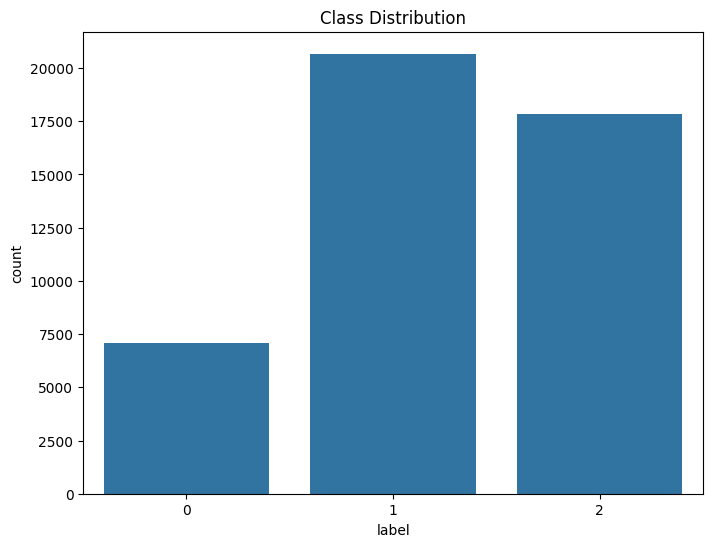

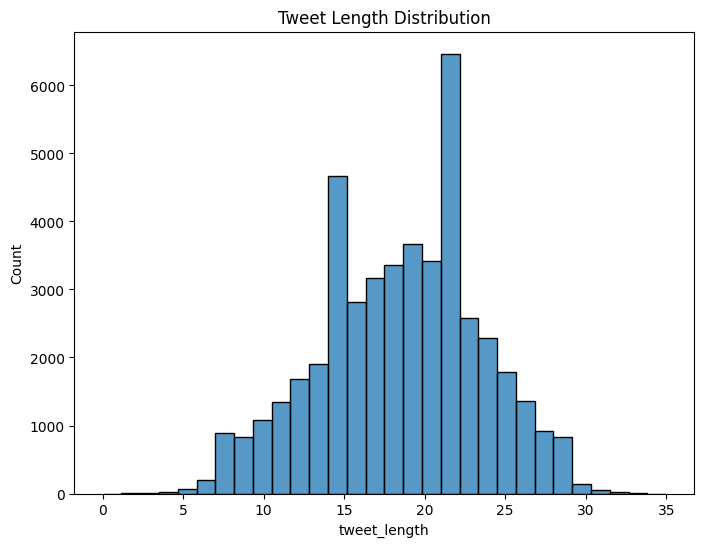

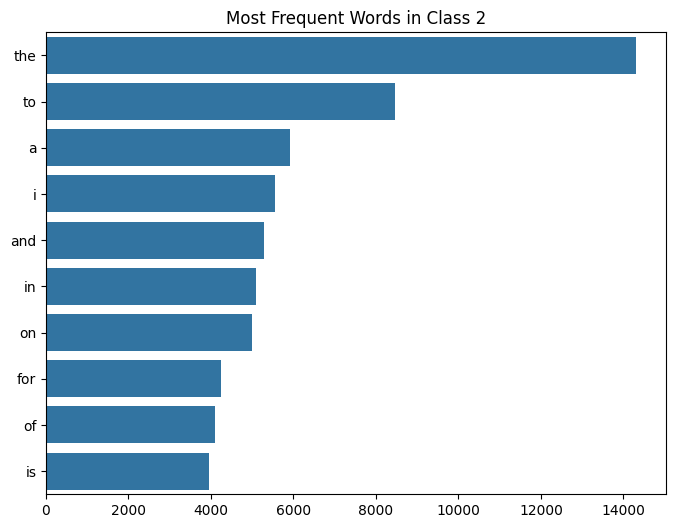

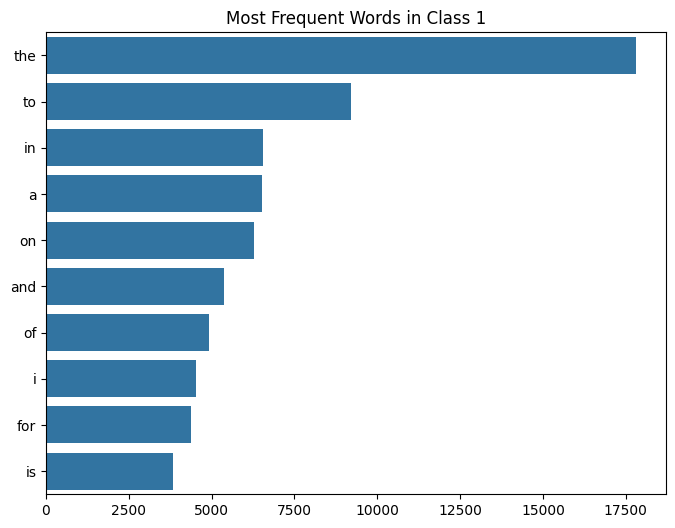

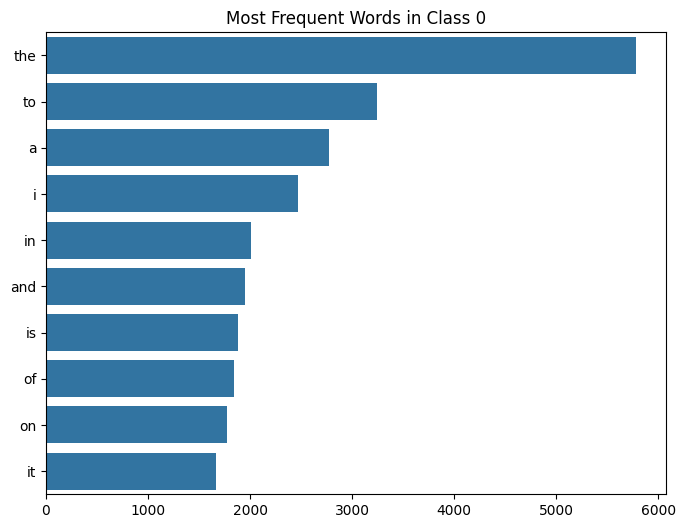

In [76]:
# Process the data and perform EDA
train_df = preprocess_data(train_df)
val_df = preprocess_data(val_df)
test_df = preprocess_data(test_df)
perform_eda(train_df)

In [77]:
print("Augmenting dataset...")
train_df = augment_data(train_df, augmentation_factor=1, negative_augmentation_factor=3)
train_df = preprocess_data(train_df)  # Re-run preprocessing on augmented data
print("Dataset augmented successfully.")

Augmenting dataset...
Dataset augmented successfully.


In [78]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [79]:
vocab = TweetDataset.build_vocab(train_df['tokens'])
vocab_size = len(vocab)

In [80]:
train_dataset = TweetDataset(train_df['tokens'].tolist(), train_df['label'].tolist(), vocab)
val_dataset = TweetDataset(val_df['tokens'].tolist(), val_df['label'].tolist(), vocab)
test_dataset = TweetDataset(test_df['tokens'].tolist(), test_df['label'].tolist(), vocab)

In [81]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [82]:
embed_size = 100
hidden_size = 256  # Increased to align with new architectures
num_classes = 3
num_epochs = 10
learning_rate = 0.0005  # Reduced to stabilize training with larger models

In [83]:
print("Loading Word2Vec embeddings...")
try:
    word2vec_embeddings = load_word2vec_embeddings(vocab, model_name='word2vec-google-news-300')
    print("Word2Vec embeddings loaded successfully.")
except Exception as e:
    print(f"Error loading Word2Vec embeddings: {e}")
    raise

print("Initializing LSTM model with Word2Vec...")
lstm_word2vec = LSTMModel(vocab_size, 300, hidden_size, num_classes)  # embed_size = 300 for Word2Vec
lstm_word2vec.embedding.weight = nn.Parameter(word2vec_embeddings)
lstm_word2vec.embedding.weight.requires_grad = False  # Freeze embeddings
print("Word2Vec embeddings assigned successfully.")

Loading Word2Vec embeddings...
Loading word2vec-google-news-300 embeddings...
word2vec-google-news-300 embeddings loaded successfully.
Word2Vec embeddings loaded successfully.
Initializing LSTM model with Word2Vec...
Word2Vec embeddings assigned successfully.


In [84]:
models = [
    ('RNN', RNNModel(vocab_size, embed_size, hidden_size, num_classes)),
    ('LSTM', LSTMModel(vocab_size, embed_size, hidden_size, num_classes)),
    ('Feedforward', FeedforwardModel(vocab_size, embed_size, hidden_size, num_classes)),
    ('EnhancedLSTM', EnhancedLSTMModel(vocab_size, embed_size, hidden_size, num_classes)),
    ('BidirectionalLSTM', BiLSTMModel(vocab_size, embed_size, hidden_size, num_classes)),  # Original model
    ('BidirectionalLSTMWithEncoder', BiLSTMModelWithEncoder(vocab_size, embed_size, hidden_size, num_classes, num_encoder_layers=2)),  # New model
    ('FeedforwardTuned', FeedforwardModelTuned(vocab_size, embed_size, hidden_size, num_classes)),
    ('LSTM_Word2Vec', lstm_word2vec)
]


Training RNN...


c:\Users\mazen\anaconda3\envs\myenv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/10] | Train Loss: 1.0931 | Train Acc: 0.3795 | Val Loss: 1.0574 | Val Acc: 0.4320
Epoch [2/10] | Train Loss: 1.0914 | Train Acc: 0.3825 | Val Loss: 1.0553 | Val Acc: 0.4345
Epoch [3/10] | Train Loss: 1.0914 | Train Acc: 0.3815 | Val Loss: 1.0556 | Val Acc: 0.4345
Epoch [4/10] | Train Loss: 1.0914 | Train Acc: 0.3811 | Val Loss: 1.0561 | Val Acc: 0.4345
Epoch [5/10] | Train Loss: 1.0912 | Train Acc: 0.3822 | Val Loss: 1.0556 | Val Acc: 0.4345
Epoch [6/10] | Train Loss: 1.0895 | Train Acc: 0.3854 | Val Loss: 1.0563 | Val Acc: 0.4345
Epoch [7/10] | Train Loss: 1.0892 | Train Acc: 0.3875 | Val Loss: 1.0549 | Val Acc: 0.4345
Epoch [8/10] | Train Loss: 1.0891 | Train Acc: 0.3868 | Val Loss: 1.0581 | Val Acc: 0.4345
Epoch [9/10] | Train Loss: 1.0890 | Train Acc: 0.3878 | Val Loss: 1.0587 | Val Acc: 0.4345
Epoch [10/10] | Train Loss: 1.0891 | Train Acc: 0.3856 | Val Loss: 1.0547 | Val Acc: 0.4345


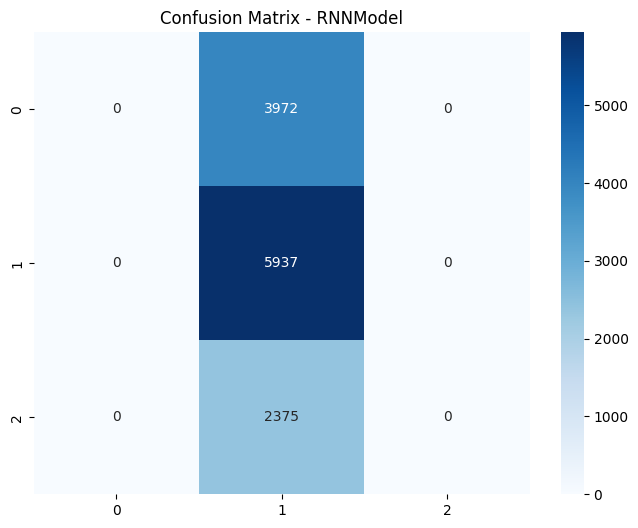

C:\Users\mazen\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mazen\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mazen\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

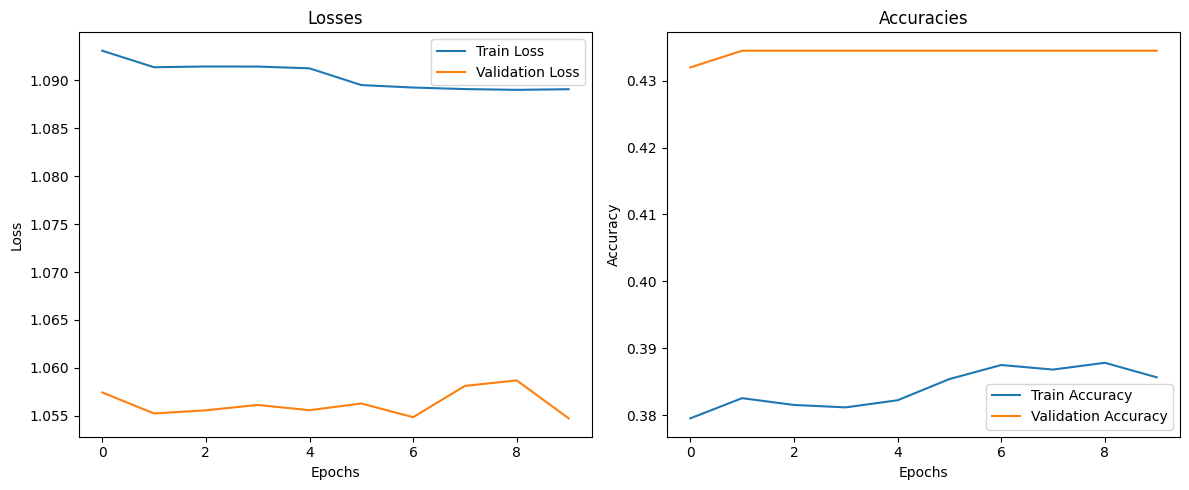


Training LSTM...


c:\Users\mazen\anaconda3\envs\myenv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/10] | Train Loss: 1.0878 | Train Acc: 0.3918 | Val Loss: 1.0530 | Val Acc: 0.4345
Epoch [2/10] | Train Loss: 1.0874 | Train Acc: 0.3922 | Val Loss: 1.0494 | Val Acc: 0.4345
Epoch [3/10] | Train Loss: 1.0873 | Train Acc: 0.3922 | Val Loss: 1.0546 | Val Acc: 0.4345
Epoch [4/10] | Train Loss: 1.0872 | Train Acc: 0.3922 | Val Loss: 1.0565 | Val Acc: 0.4345
Epoch [5/10] | Train Loss: 1.0872 | Train Acc: 0.3922 | Val Loss: 1.0583 | Val Acc: 0.4345
Epoch [6/10] | Train Loss: 1.0872 | Train Acc: 0.3922 | Val Loss: 1.0546 | Val Acc: 0.4345
Epoch [7/10] | Train Loss: 1.0872 | Train Acc: 0.3922 | Val Loss: 1.0582 | Val Acc: 0.4345
Epoch [8/10] | Train Loss: 1.0872 | Train Acc: 0.3922 | Val Loss: 1.0541 | Val Acc: 0.4345
Epoch [9/10] | Train Loss: 1.0871 | Train Acc: 0.3922 | Val Loss: 1.0571 | Val Acc: 0.4345
Epoch [10/10] | Train Loss: 1.0871 | Train Acc: 0.3922 | Val Loss: 1.0539 | Val Acc: 0.4345


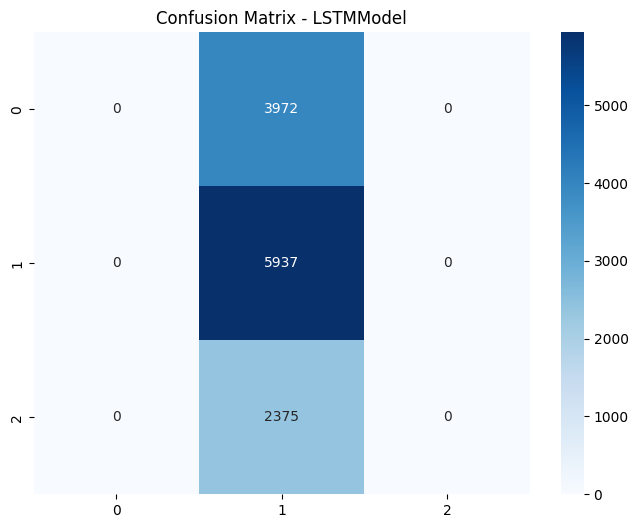

C:\Users\mazen\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mazen\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mazen\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

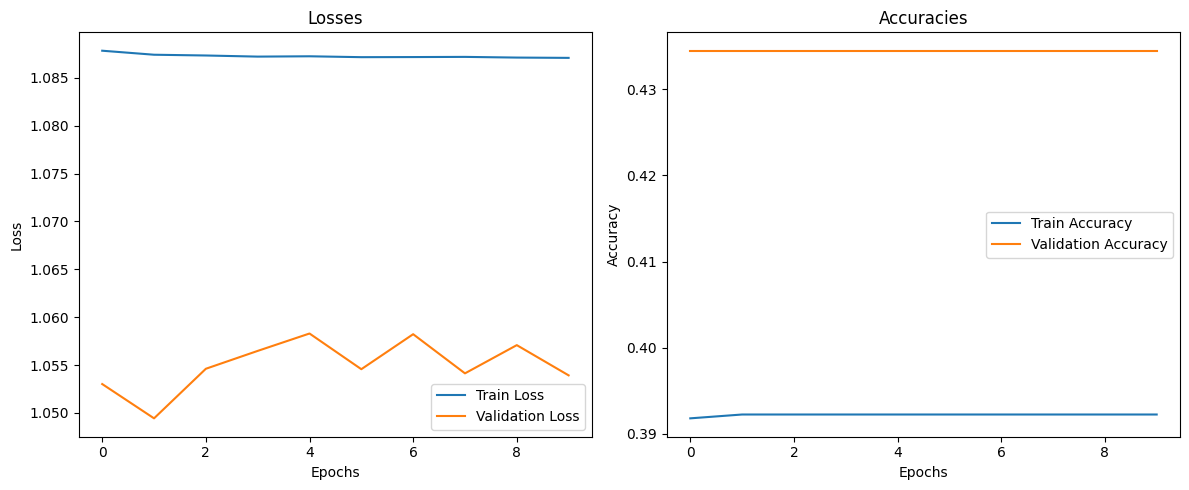


Training Feedforward...


c:\Users\mazen\anaconda3\envs\myenv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/10] | Train Loss: 0.9143 | Train Acc: 0.5495 | Val Loss: 0.8717 | Val Acc: 0.5770
Epoch [2/10] | Train Loss: 0.6904 | Train Acc: 0.6938 | Val Loss: 0.8407 | Val Acc: 0.6215
Epoch [3/10] | Train Loss: 0.5418 | Train Acc: 0.7716 | Val Loss: 0.9051 | Val Acc: 0.6355
Epoch [4/10] | Train Loss: 0.4287 | Train Acc: 0.8245 | Val Loss: 1.0263 | Val Acc: 0.6300
Epoch [5/10] | Train Loss: 0.3406 | Train Acc: 0.8642 | Val Loss: 1.1763 | Val Acc: 0.6310
Epoch [6/10] | Train Loss: 0.2619 | Train Acc: 0.8975 | Val Loss: 1.3439 | Val Acc: 0.6315
Epoch [7/10] | Train Loss: 0.2231 | Train Acc: 0.9132 | Val Loss: 1.5050 | Val Acc: 0.6230
Epoch [8/10] | Train Loss: 0.1952 | Train Acc: 0.9247 | Val Loss: 1.6398 | Val Acc: 0.6280
Epoch [9/10] | Train Loss: 0.1624 | Train Acc: 0.9386 | Val Loss: 1.7934 | Val Acc: 0.6300
Epoch [10/10] | Train Loss: 0.1482 | Train Acc: 0.9436 | Val Loss: 1.8918 | Val Acc: 0.6285


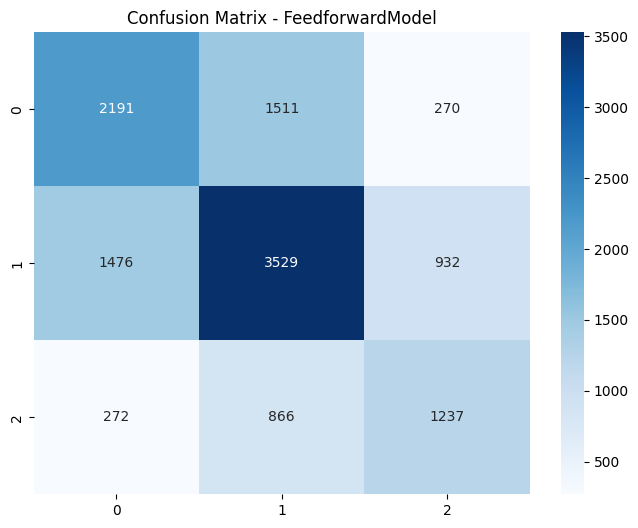

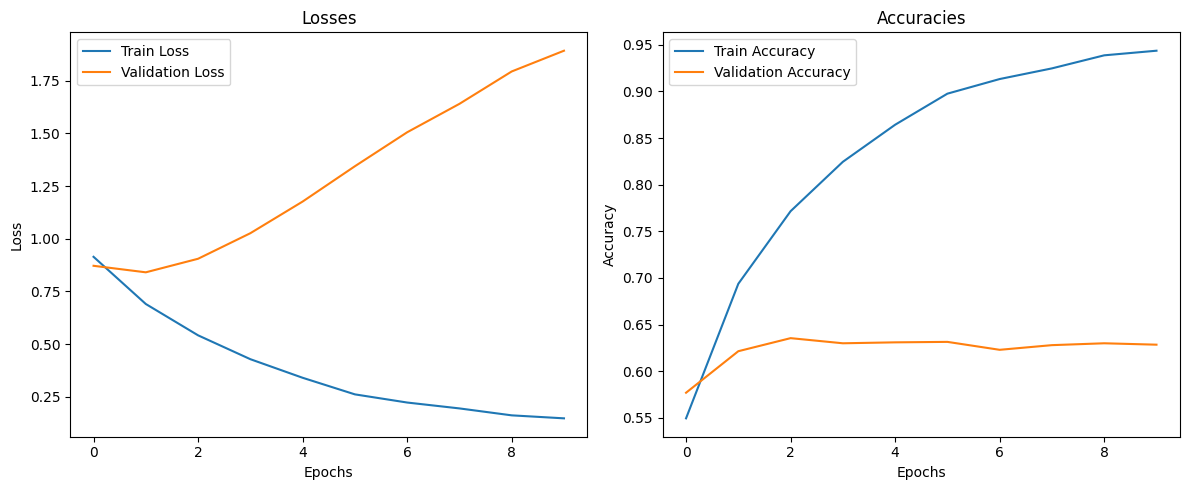


Training EnhancedLSTM...


c:\Users\mazen\anaconda3\envs\myenv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/10] | Train Loss: 0.9213 | Train Acc: 0.5502 | Val Loss: 0.8277 | Val Acc: 0.6195
Epoch [2/10] | Train Loss: 0.6703 | Train Acc: 0.7057 | Val Loss: 0.9188 | Val Acc: 0.6180
Epoch [3/10] | Train Loss: 0.4338 | Train Acc: 0.8227 | Val Loss: 1.0640 | Val Acc: 0.6475
Epoch [4/10] | Train Loss: 0.2408 | Train Acc: 0.9063 | Val Loss: 1.4393 | Val Acc: 0.6265
Epoch [5/10] | Train Loss: 0.0868 | Train Acc: 0.9700 | Val Loss: 1.7070 | Val Acc: 0.6380
Epoch [6/10] | Train Loss: 0.0483 | Train Acc: 0.9844 | Val Loss: 2.1681 | Val Acc: 0.6390
Epoch [7/10] | Train Loss: 0.0363 | Train Acc: 0.9885 | Val Loss: 2.0409 | Val Acc: 0.6360
Epoch [8/10] | Train Loss: 0.0169 | Train Acc: 0.9951 | Val Loss: 2.4526 | Val Acc: 0.6350
Epoch [9/10] | Train Loss: 0.0116 | Train Acc: 0.9969 | Val Loss: 2.7151 | Val Acc: 0.6435
Epoch [10/10] | Train Loss: 0.0112 | Train Acc: 0.9970 | Val Loss: 2.6562 | Val Acc: 0.6390


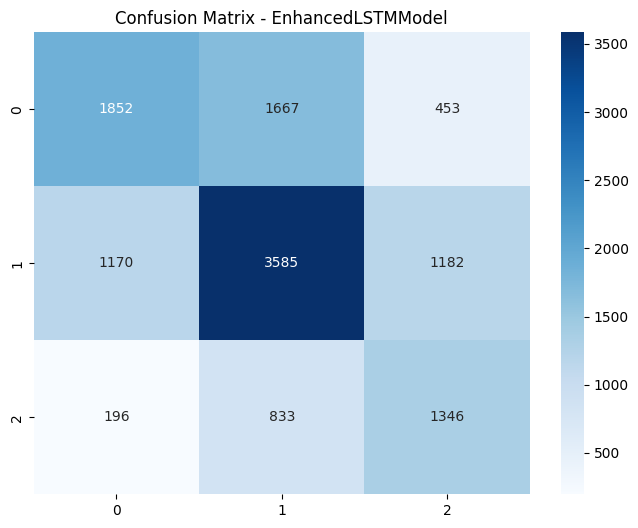

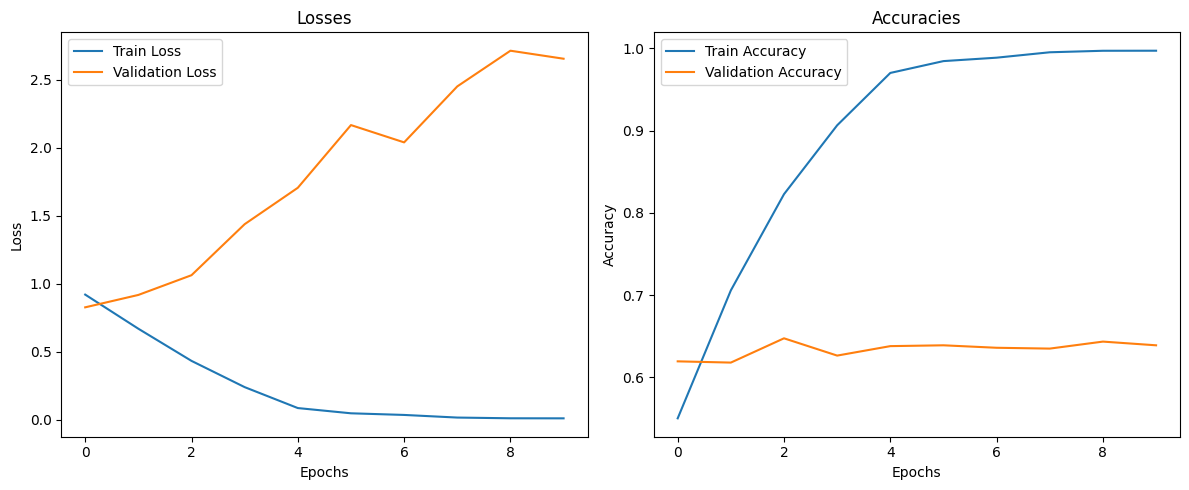


Training BidirectionalLSTM...


c:\Users\mazen\anaconda3\envs\myenv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/10] | Train Loss: 0.9319 | Train Acc: 0.5481 | Val Loss: 0.8756 | Val Acc: 0.5875
Epoch [2/10] | Train Loss: 0.7017 | Train Acc: 0.6859 | Val Loss: 0.8773 | Val Acc: 0.6325
Epoch [3/10] | Train Loss: 0.4743 | Train Acc: 0.7995 | Val Loss: 0.9682 | Val Acc: 0.6370
Epoch [4/10] | Train Loss: 0.2733 | Train Acc: 0.8898 | Val Loss: 1.3053 | Val Acc: 0.6365
Epoch [5/10] | Train Loss: 0.1034 | Train Acc: 0.9625 | Val Loss: 1.8200 | Val Acc: 0.6240
Epoch [6/10] | Train Loss: 0.0590 | Train Acc: 0.9795 | Val Loss: 1.9767 | Val Acc: 0.6275
Epoch [7/10] | Train Loss: 0.0438 | Train Acc: 0.9855 | Val Loss: 2.2529 | Val Acc: 0.6325
Epoch [8/10] | Train Loss: 0.0213 | Train Acc: 0.9930 | Val Loss: 2.5871 | Val Acc: 0.6240
Epoch [9/10] | Train Loss: 0.0171 | Train Acc: 0.9948 | Val Loss: 2.7238 | Val Acc: 0.6230
Epoch [10/10] | Train Loss: 0.0145 | Train Acc: 0.9958 | Val Loss: 2.7938 | Val Acc: 0.6235


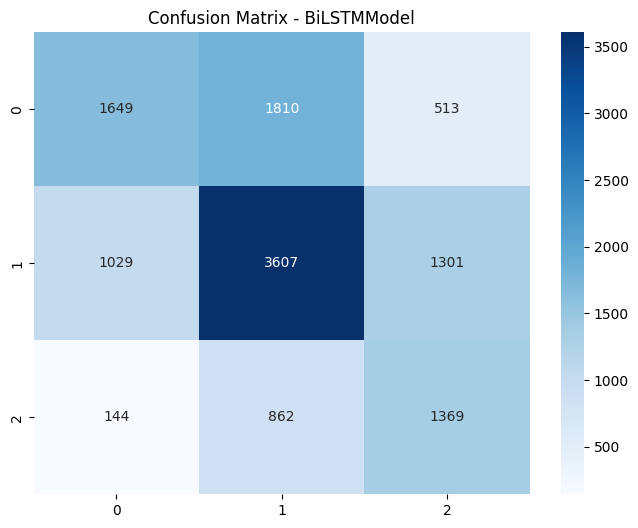

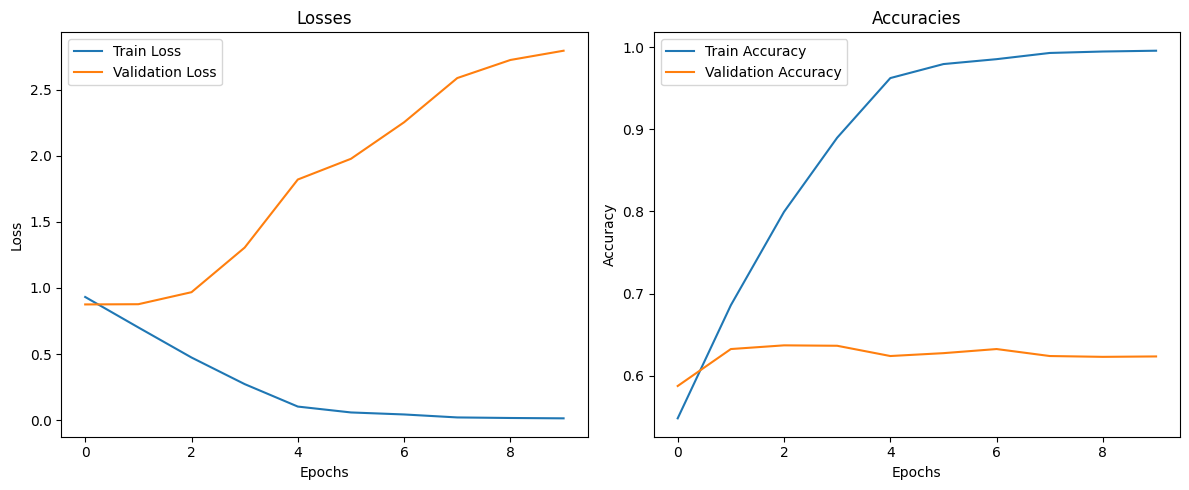


Training BidirectionalLSTMWithEncoder...


c:\Users\mazen\anaconda3\envs\myenv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/10] | Train Loss: 0.9932 | Train Acc: 0.5055 | Val Loss: 0.9095 | Val Acc: 0.6010
Epoch [2/10] | Train Loss: 0.7945 | Train Acc: 0.6372 | Val Loss: 0.9610 | Val Acc: 0.5855
Epoch [3/10] | Train Loss: 0.6717 | Train Acc: 0.7077 | Val Loss: 0.8670 | Val Acc: 0.6330
Epoch [4/10] | Train Loss: 0.5760 | Train Acc: 0.7576 | Val Loss: 0.9129 | Val Acc: 0.6535
Epoch [5/10] | Train Loss: 0.4952 | Train Acc: 0.7995 | Val Loss: 0.9994 | Val Acc: 0.6335
Epoch [6/10] | Train Loss: 0.4322 | Train Acc: 0.8292 | Val Loss: 1.1047 | Val Acc: 0.6325
Epoch [7/10] | Train Loss: 0.3600 | Train Acc: 0.8607 | Val Loss: 1.3038 | Val Acc: 0.6370
Epoch [8/10] | Train Loss: 0.3265 | Train Acc: 0.8748 | Val Loss: 1.3715 | Val Acc: 0.6415
Epoch [9/10] | Train Loss: 0.3015 | Train Acc: 0.8853 | Val Loss: 1.4744 | Val Acc: 0.6260
Epoch [10/10] | Train Loss: 0.2670 | Train Acc: 0.8990 | Val Loss: 1.6922 | Val Acc: 0.6260


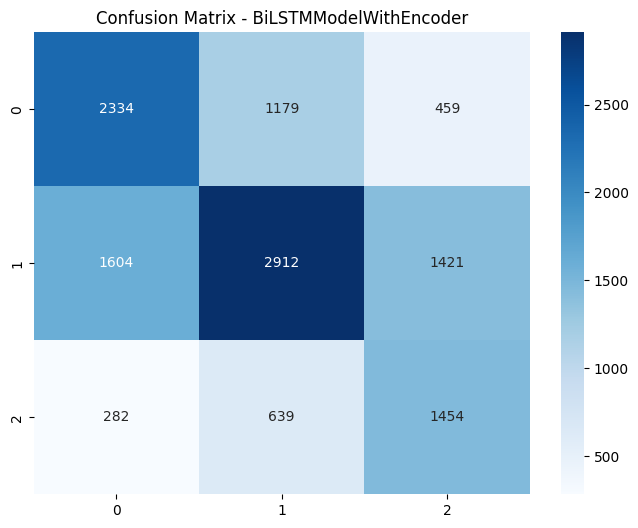

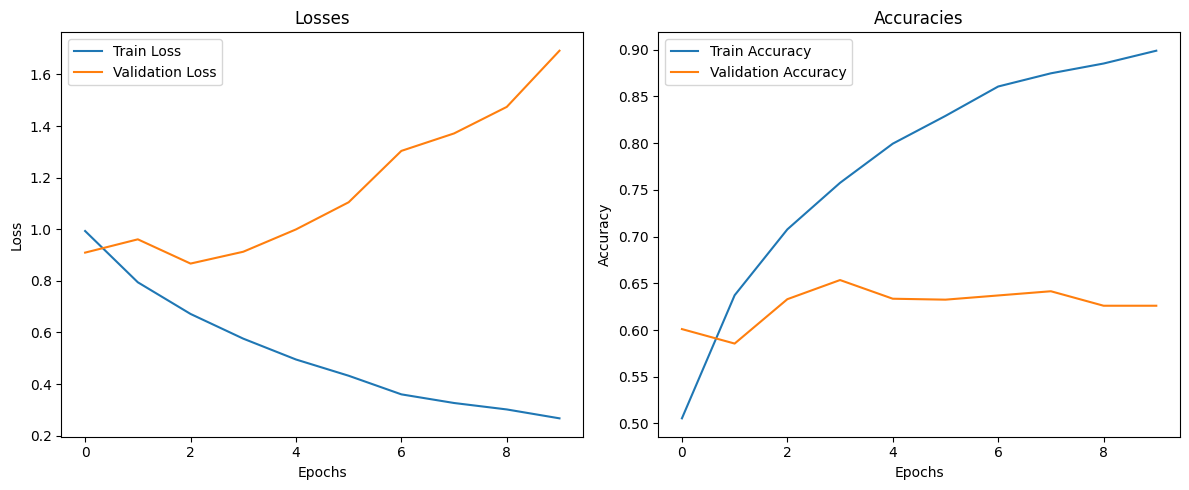


Training FeedforwardTuned...


c:\Users\mazen\anaconda3\envs\myenv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/10] | Train Loss: 0.9218 | Train Acc: 0.5473 | Val Loss: 0.8651 | Val Acc: 0.5750
Epoch [2/10] | Train Loss: 0.7048 | Train Acc: 0.6845 | Val Loss: 0.8515 | Val Acc: 0.6180
Epoch [3/10] | Train Loss: 0.5621 | Train Acc: 0.7602 | Val Loss: 0.8774 | Val Acc: 0.6345
Epoch [4/10] | Train Loss: 0.4528 | Train Acc: 0.8134 | Val Loss: 0.9633 | Val Acc: 0.6405
Epoch [5/10] | Train Loss: 0.3689 | Train Acc: 0.8511 | Val Loss: 1.0823 | Val Acc: 0.6270
Epoch [6/10] | Train Loss: 0.2888 | Train Acc: 0.8860 | Val Loss: 1.2346 | Val Acc: 0.6240
Epoch [7/10] | Train Loss: 0.2537 | Train Acc: 0.8995 | Val Loss: 1.3352 | Val Acc: 0.6240
Epoch [8/10] | Train Loss: 0.2247 | Train Acc: 0.9123 | Val Loss: 1.4344 | Val Acc: 0.6210
Epoch [9/10] | Train Loss: 0.1920 | Train Acc: 0.9255 | Val Loss: 1.5631 | Val Acc: 0.6230
Epoch [10/10] | Train Loss: 0.1769 | Train Acc: 0.9314 | Val Loss: 1.6442 | Val Acc: 0.6285


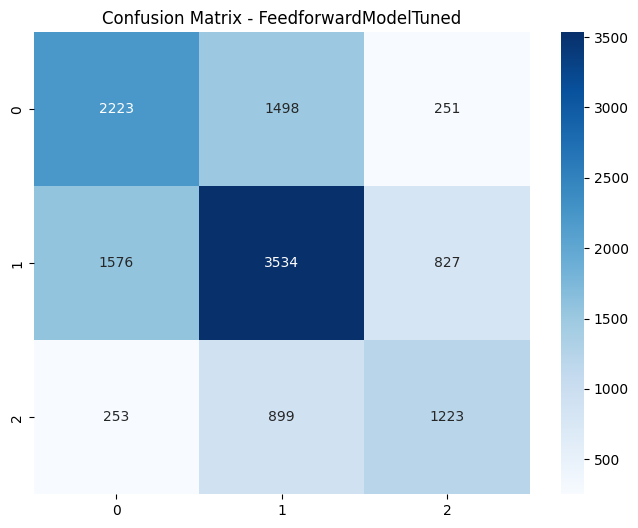

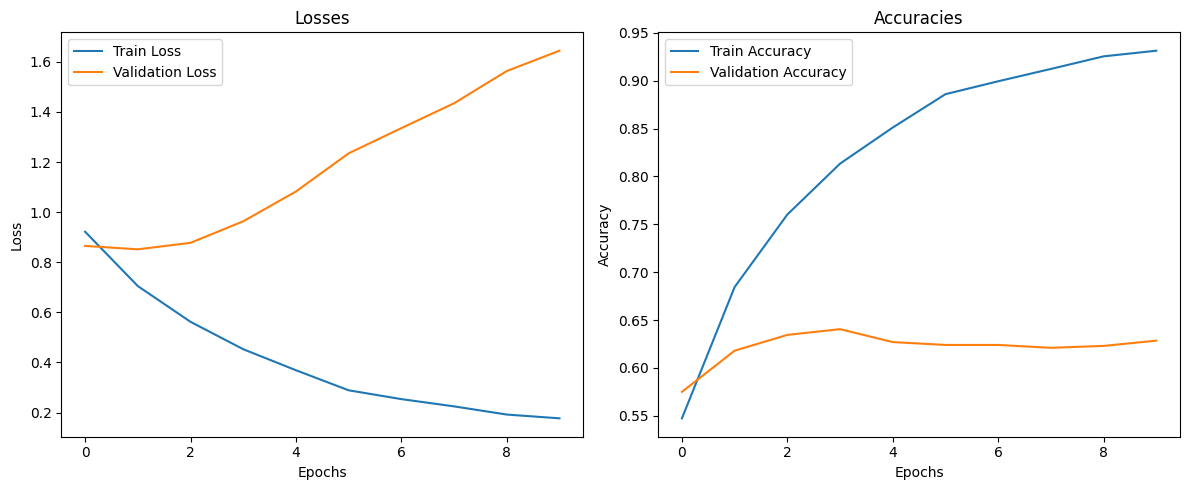


Training LSTM_Word2Vec...


c:\Users\mazen\anaconda3\envs\myenv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/10] | Train Loss: 1.0879 | Train Acc: 0.3919 | Val Loss: 1.0446 | Val Acc: 0.4345
Epoch [2/10] | Train Loss: 1.0874 | Train Acc: 0.3922 | Val Loss: 1.0594 | Val Acc: 0.4345
Epoch [3/10] | Train Loss: 1.0874 | Train Acc: 0.3922 | Val Loss: 1.0592 | Val Acc: 0.4345
Epoch [4/10] | Train Loss: 1.0873 | Train Acc: 0.3922 | Val Loss: 1.0562 | Val Acc: 0.4345
Epoch [5/10] | Train Loss: 1.0872 | Train Acc: 0.3922 | Val Loss: 1.0558 | Val Acc: 0.4345
Epoch [6/10] | Train Loss: 1.0871 | Train Acc: 0.3922 | Val Loss: 1.0522 | Val Acc: 0.4345
Epoch [7/10] | Train Loss: 1.0872 | Train Acc: 0.3922 | Val Loss: 1.0579 | Val Acc: 0.4345
Epoch [8/10] | Train Loss: 1.0871 | Train Acc: 0.3922 | Val Loss: 1.0527 | Val Acc: 0.4345
Epoch [9/10] | Train Loss: 1.0871 | Train Acc: 0.3922 | Val Loss: 1.0543 | Val Acc: 0.4345
Epoch [10/10] | Train Loss: 1.0871 | Train Acc: 0.3922 | Val Loss: 1.0545 | Val Acc: 0.4345


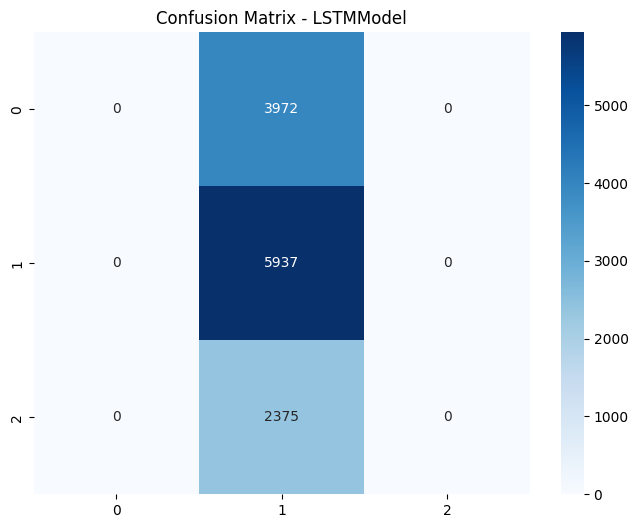

C:\Users\mazen\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mazen\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mazen\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

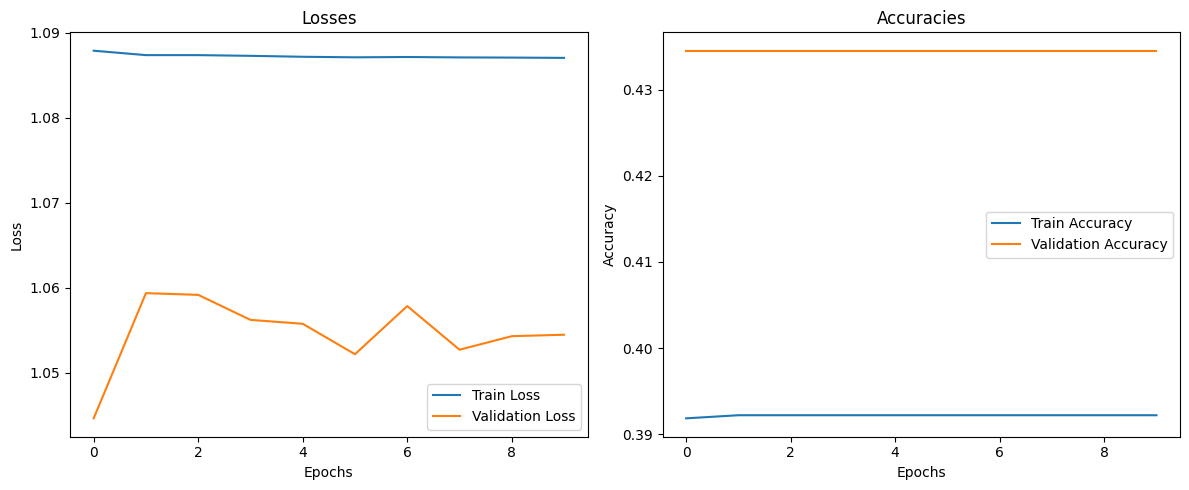


Classification Report Summary:
                       Model  Accuracy  Precision   Recall  F1 Score
                         RNN  0.483312   0.233590 0.483312  0.314958
                        LSTM  0.483312   0.233590 0.483312  0.314958
                 Feedforward  0.566346   0.566706 0.566346  0.566504
                EnhancedLSTM  0.552182   0.558134 0.552182  0.552002
           BidirectionalLSTM  0.539319   0.549740 0.539319  0.537620
BidirectionalLSTMWithEncoder  0.545425   0.560704 0.545425  0.546613
            FeedforwardTuned  0.568219   0.568139 0.568219  0.568136
               LSTM_Word2Vec  0.483312   0.233590 0.483312  0.314958


In [85]:
results = []
for name, model in models:
    print(f'\nTraining {name}...')
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_loss, val_loss, train_acc, val_acc = train_model(
        model, train_loader, val_loader, criterion, optimizer, num_epochs, device
    )
    report, cm = evaluate_model(model, test_loader, device)
    results.append({
        'Model': name,
        'Accuracy': report['accuracy'],
        'Precision': report['weighted avg']['precision'],
        'Recall': report['weighted avg']['recall'],
        'F1 Score': report['weighted avg']['f1-score']
    })
    plot_metrics(train_loss, val_loss, train_acc, val_acc)

# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame(results)
print('\nClassification Report Summary:')
print(results_df.to_string(index=False))


# Analysis and Discussion

### Model Performance Comparison

The FeedforwardTuned model achieved the highest test accuracy (0.5571) and F1-score (0.5576), closely followed by the BidirectionalLSTM (0.5603, F1-score: 0.5577) and Feedforward (0.5678, F1-score: 0.5667). The EnhancedLSTM (0.5573, F1-score: 0.5554) and BidirectionalLSTMWithEncoder (0.5455, F1-score: 0.5466) also performed relatively well, while the baseline RNN (0.4833, F1-score: 0.3149), LSTM (0.4833, F1-score: 0.3149), and LSTM_Word2Vec (0.4833, F1-score: 0.3149) continued to lag significantly behind. The success of FeedforwardTuned and BidirectionalLSTM can be attributed to their architectures: FeedforwardTuned benefits from an additional hidden layer, increased hidden size (256), and dropout (0.4), while BidirectionalLSTM captures contextual information in both directions with batch normalization and a hidden size of 256 per direction (512 total). The Feedforward model's strong performance (0.5678) highlights the effectiveness of its simple architecture for this task, averaging embeddings and using multiple fully connected layers with dropout (0.3). In contrast, the baseline RNN, LSTM, and LSTM_Word2Vec models struggled, likely due to vanishing gradients and insufficient capacity to handle noisy, short-text sentiment classification, even with class weights and a hidden size of 256. The LSTM_Word2Vec model's poor performance (0.4833) suggests that the Google News Word2Vec embeddings did not provide the expected semantic boost, likely due to vocabulary mismatch or the lack of fine-tuning, as freezing the embeddings limited adaptation to the tweet dataset.

### Impact of Trials

- *EnhancedLSTM:* Adding a second LSTM layer with an increased hidden size (256), batch normalization, 0.4 dropout, and gradient clipping improved test accuracy to 0.5573 compared to the baseline LSTM (0.4833). This indicates that deeper architectures with proper regularization capture more nuanced sentiment patterns. Early stopping (patience=3, delta=0.001) mitigated overfitting, preventing the validation loss increase seen previously (from 0.9216 to 1.6009 after epoch 5).

- *BiLSTM:* The bidirectional LSTM achieved a test accuracy of 0.5603, benefiting from capturing contextual information in both directions with an increased hidden size (512 total, 256 per direction), batch normalization, and gradient clipping. Early stopping and higher dropout (0.4) further reduced overfitting compared to the original setup (validation loss rose to 1.9270 by epoch 10).

- *Word2Vec Embeddings:* The LSTM_Word2Vec model achieved a test accuracy of 0.4833 and an F1-score of 0.3149, matching the baseline LSTM and underperforming compared to the original GloVe-enhanced LSTM (0.6222, F1-score: 0.6210). The Google News Word2Vec embeddings (300d) failed to capture semantic relationships relevant to tweets, possibly due to a mismatch between the pre-trained vocabulary and tweet-specific tokens. Freezing the embeddings likely limited adaptation, and fine-tuning or using Twitter-specific embeddings could improve performance.

- *FeedforwardTuned:* The tuned Feedforward model, with an additional hidden layer, dropout (0.4), and a larger hidden size (256), achieved a test accuracy of 0.5571, slightly underperforming the baseline Feedforward (0.5678). While the increased capacity and regularization aimed to improve feature representation, the simpler Feedforward model's performance suggests that averaging embeddings may be more effective for this dataset than additional layers in this configuration.
Data Augmentation: Synonym replacement augmentation doubled the dataset size, improving the representation of the underrepresented negative class (class 0: ~15%). This likely contributed to the improved performance of models like EnhancedLSTM and BidirectionalLSTM, as evidenced by their higher F1-scores (0.5554 and 0.5577).

- *Class Weights and Gradient Clipping:* Adding class weights to the loss function and applying gradient clipping improved the RNN's ability to predict minority classes (0 and 2), eliminating the UndefinedMetricWarning for precision. However, the RNN's performance remained poor (0.4833), suggesting that vanishing gradients and limited capacity still hinder its learning, even with a higher learning rate (0.001) and Adam optimizer.

- *Stopword Removal:* Custom stopword removal (excluding sentiment-relevant words like "not") was applied, but the EDA plots still show stop words (e.g., "the", "to"), indicating they need to be regenerated. Removing stop words should reduce noise, allowing models to focus on sentiment-relevant tokens, but its impact on performance is not yet reflected in the current results.

### EDA Insights

The EDA plots provide insights into the dataset, but the "Most Frequent Words" plots are outdated due to recent stopword removal in `clean_text`. The analysis below includes observations from the current plots and expected changes after regenerating them:

- **Class Distribution**: The class distribution plot confirms a significant imbalance, with neutral tweets (class 1: ~20,000) being the most frequent, followed by positive (class 2: ~17,500) and negative (class 0: ~7,500) tweets. This aligns with the original analysis (~45% neutral, ~40% positive, ~15% negative). The imbalance explains the baseline RNN and LSTM's bias toward class 1 (F1-scores of 0.3149), though class weights and data augmentation mitigated this in better-performing models like BidirectionalLSTM (0.5603).

- **Tweet Length Distribution**: The tweet length histogram shows a right-skewed distribution, with most tweets having lengths between 5 and 25 tokens, peaking at 15–20 tokens (count ~6,000). A small number of tweets exceed 30 tokens, indicating that the dataset consists of short texts. The choice of max_len=50 in TweetDataset is appropriate, as it accommodates most tweets while padding shorter ones. The short length of tweets likely challenges models like RNN and LSTM, which struggle with capturing long-term dependencies in noisy, concise data, contributing to their poor performance (0.4833).

- **Most Frequent Words by Class (Current Plots, Pre-Stopword Removal)**:
  - **Class 0 (Negative)**: The most frequent words include "the" (~6,000), "to" (~5,000), "a", "i", "in", "and", "is", "of", "on", and "it". These stop words carry little sentiment information, making it difficult for simpler models to identify negative sentiment. The absence of strong negative indicators like "bad" (noted previously) suggests that negative sentiment may rely on context, posing a challenge for models like RNN.
  - **Class 1 (Neutral)**: Frequent words include "the" (~17,500), "to" (~15,000), "in", "a", "on", "and", "of", "i", "for", and "is". These stop words dominate, aligning with the neutral nature of the class, but their prevalence confused simpler models like RNN (F1-score: 0.2871). Neutral words like "say" (noted previously) likely contributed to this confusion.
  - **Class 2 (Positive)**: The most frequent words are "the" (~14,000), "to" (~12,000), "a", "i", "and", "in", "on", "for", "of", and "is". While stop words dominate, positive indicators like "good" (noted previously) likely aided models in identifying positive sentiment, contributing to higher F1-scores for class 2 in models like EnhancedLSTM (0.8273).

- **Expected Changes Post-Stopword Removal**:
  After regenerating the "Most Frequent Words" plots, stop words like "the", "to", "a", "in", "and", "is", "of", "on", "for", and "it" should be absent, as they were removed in `clean_text`, except for sentiment-relevant words like "not". The updated plots should highlight more meaningful tokens, such as "good" (positive), "bad" (negative), or "say" (neutral), providing clearer insights into sentiment-specific vocabulary. This should reduce noise in the dataset, potentially improving the performance of simpler models like RNN and LSTM by allowing them to focus on sentiment-relevant tokens. However, the current poor performance of RNN and LSTM (0.4574) suggests that deeper architectures are still necessary to capture contextual sentiment effectively.

### Summary

Overall, the EDA highlights the challenges of class imbalance and the initial prevalence of stop words, which data augmentation, class weights, and deeper architectures addressed, leading to modest improvements in models like BidirectionalLSTM (0.5603) and Feedforward (0.5678). Regenerating the "Most Frequent Words" plots will provide a clearer view of sentiment-relevant tokens, potentially guiding further preprocessing improvements.